In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch

In [3]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
!nvidia-smi

Fri Sep 10 13:52:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import pickle,tqdm
import numpy as np

In [6]:
pickle_data_path = '/content/drive/MyDrive/rar_stock_brain/data- all hours/Hour7'

In [7]:
with open(pickle_data_path,'rb') as f:
  data = pickle.load(f)

In [8]:
import matplotlib.pyplot as plt

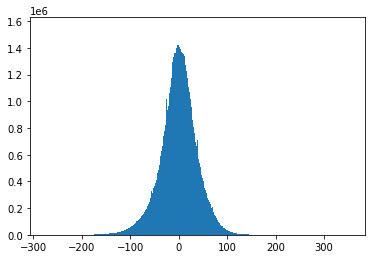

In [9]:
# histogram of the data
p = plt.hist(data,bins=400)

In [10]:
# data_clipped = data.clip(max=50,min=-50)

In [11]:
# mean = data.mean()
# std = data.std()
# data = (data - mean) / std

set the working path to the LSTM_encoder_decoder/code path

In [12]:
cd /content/drive/MyDrive/rar_stock_brain/LSTM_encoder_decoder/code/

/content/drive/MyDrive/rar_stock_brain/LSTM_encoder_decoder/code


the following is based on :
https://github.com/lkulowski/LSTM_encoder_decoder.git

In [13]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
import sys

import generate_dataset
import lstm_encoder_decoder
import plotting 

import matplotlib.pyplot as pl
from scipy import signal


matplotlib.rcParams.update({'font.size': 17})

Resample the signal from 20khz to 250hz for easier model construction and training, also the signal is amplified by 100 in order to 
magnify the MSE loss

In [14]:
############## DOWNSAMPLE from 20000Hz to 250Hz ################
new_sr = 250
current_sr = 20000
signal_amplification = 0.25


resample_ratio =current_sr /new_sr
from scipy import signal
f = signal.resample(data, int((data.shape[0] / current_sr)*new_sr))
tnew = np.arange(0,data.shape[0],resample_ratio)
t = np.arange(0,data.shape[0],1)

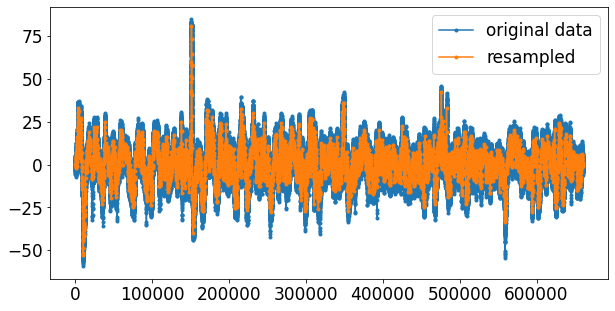

In [15]:
import matplotlib.pyplot as pl
f = f*signal_amplification
l = int(660000/resample_ratio)
plt.figure(figsize=(10,5))
plt.plot(t[:660000], data[:660000]*signal_amplification, '.-',tnew[:l], f[:l], '.-')
plt.legend(['original data', 'resampled'], loc='best')
plt.show()

In [16]:
y, t = f, tnew

80% goes for train split and 20% for validation

In [17]:
t_train, y_train, t_test, y_test = generate_dataset.train_test_split(t, y, split = 0.8)


##split the data using sliding window to input segments and label segments of size:

iw = 250 # past data to pass (to predict next samples)

ow = 25 # samples to predict

s = 5 # overlap between windows (steps to start iw)


In [18]:
# set size of input/output windows 
iw = 250 # past data to pass (to predict next samples)
ow = 25 # samples to predict
s = 5 # overlap between windows (steps to start iw)

# generate windowed training/test datasets
Xtrain, Ytrain= generate_dataset.windowed_dataset(y_train, input_window = iw, output_window = ow, stride = s)
Xtest, Ytest = generate_dataset.windowed_dataset(y_test, input_window = iw, output_window = ow, stride = s)

# plot example of windowed data  


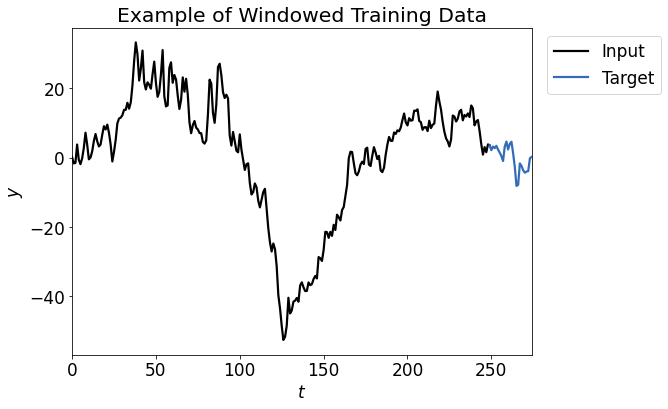

In [19]:
plt.figure(figsize = (10, 6)) 
plt.plot(np.arange(0, iw), Xtrain[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, 0, 0]], Ytrain[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 
plt.savefig('plots/windowed_data.png')

In [20]:
# LSTM encoder-decoder

# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)


In [21]:

# specify model parameters and train
model = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 30)

In [22]:
model

lstm_seq2seq(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 30)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 30)
    (linear): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [23]:
# model = lstm_encoder_decoder.lstm_seq2seq(input_size = X_train.shape[2], hidden_size = 30,attn=True, in_seq_len=iw)
loss = model.train_model(X_train, Y_train, n_epochs = 400, target_len = ow, batch_size = 500, training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.7, learning_rate = 0.005, dynamic_tf = False, cosineAn=True)

  0%|          | 0/400 [00:00<?, ?it/s]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  0%|          | 1/400 [00:06<45:43,  6.88s/it, loss=44.084]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  0%|          | 2/400 [00:13<44:54,  6.77s/it, loss=20.425]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  1%|          | 3/400 [00:20<44:27,  6.72s/it, loss=15.470]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  1%|          | 4/400 [00:26<44:18,  6.71s/it, loss=13.252]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  1%|▏         | 5/400 [00:33<44:03,  6.69s/it, loss=10.831]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  2%|▏         | 6/400 [00:40<43:52,  6.68s/it, loss=9.641]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  2%|▏         | 7/400 [00:46<43:39,  6.67s/it, loss=9.498]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  2%|▏         | 8/400 [00:53<43:27,  6.65s/it, loss=8.323]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  2%|▏         | 9/400 [01:00<43:16,  6.64s/it, loss=7.477]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  2%|▎         | 10/400 [01:06<43:05,  6.63s/it, loss=7.102]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  3%|▎         | 11/400 [01:13<43:03,  6.64s/it, loss=15.923]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  3%|▎         | 12/400 [01:20<43:05,  6.66s/it, loss=15.077]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  3%|▎         | 13/400 [01:26<42:55,  6.66s/it, loss=13.862]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  4%|▎         | 14/400 [01:33<42:50,  6.66s/it, loss=13.087]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  4%|▍         | 15/400 [01:40<42:45,  6.66s/it, loss=12.220]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  4%|▍         | 16/400 [01:46<42:39,  6.67s/it, loss=11.451]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  4%|▍         | 17/400 [01:53<42:27,  6.65s/it, loss=11.179]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  4%|▍         | 18/400 [01:59<42:17,  6.64s/it, loss=10.445]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  5%|▍         | 19/400 [02:06<42:06,  6.63s/it, loss=10.966]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  5%|▌         | 20/400 [02:13<42:01,  6.64s/it, loss=11.232]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  5%|▌         | 21/400 [02:19<42:00,  6.65s/it, loss=9.606]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  6%|▌         | 22/400 [02:26<42:12,  6.70s/it, loss=9.249]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  6%|▌         | 23/400 [02:33<41:59,  6.68s/it, loss=8.798]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  6%|▌         | 24/400 [02:39<41:43,  6.66s/it, loss=8.524]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  6%|▋         | 25/400 [02:46<41:36,  6.66s/it, loss=8.366]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  6%|▋         | 26/400 [02:53<41:28,  6.65s/it, loss=8.207]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  7%|▋         | 27/400 [02:59<41:24,  6.66s/it, loss=8.301]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  7%|▋         | 28/400 [03:06<41:15,  6.65s/it, loss=7.499]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  7%|▋         | 29/400 [03:13<41:11,  6.66s/it, loss=7.175]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  8%|▊         | 30/400 [03:19<40:54,  6.64s/it, loss=7.094]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  8%|▊         | 31/400 [03:26<40:53,  6.65s/it, loss=7.011]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  8%|▊         | 32/400 [03:33<40:48,  6.65s/it, loss=6.767]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  8%|▊         | 33/400 [03:39<40:40,  6.65s/it, loss=6.669]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  8%|▊         | 34/400 [03:46<40:31,  6.64s/it, loss=7.162]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  9%|▉         | 35/400 [03:53<40:24,  6.64s/it, loss=6.407]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  9%|▉         | 36/400 [03:59<40:19,  6.65s/it, loss=6.362]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


  9%|▉         | 37/400 [04:06<40:11,  6.64s/it, loss=6.110]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 10%|▉         | 38/400 [04:13<40:05,  6.65s/it, loss=6.203]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 10%|▉         | 39/400 [04:19<40:08,  6.67s/it, loss=6.088]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 10%|█         | 40/400 [04:26<40:09,  6.69s/it, loss=6.173]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 10%|█         | 41/400 [04:33<40:02,  6.69s/it, loss=6.095]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 10%|█         | 42/400 [04:39<39:55,  6.69s/it, loss=5.945]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 11%|█         | 43/400 [04:46<39:45,  6.68s/it, loss=5.821]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 11%|█         | 44/400 [04:53<39:32,  6.67s/it, loss=5.627]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 11%|█▏        | 45/400 [04:59<39:23,  6.66s/it, loss=5.638]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 12%|█▏        | 46/400 [05:06<39:18,  6.66s/it, loss=11.666]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 12%|█▏        | 47/400 [05:13<39:08,  6.65s/it, loss=13.571]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 12%|█▏        | 48/400 [05:19<38:59,  6.65s/it, loss=12.113]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 12%|█▏        | 49/400 [05:26<38:58,  6.66s/it, loss=11.909]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 12%|█▎        | 50/400 [05:33<38:55,  6.67s/it, loss=10.837]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 13%|█▎        | 51/400 [05:39<38:51,  6.68s/it, loss=10.060]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 13%|█▎        | 52/400 [05:46<38:46,  6.69s/it, loss=10.342]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 13%|█▎        | 53/400 [05:53<38:35,  6.67s/it, loss=9.354]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 14%|█▎        | 54/400 [05:59<38:21,  6.65s/it, loss=8.826]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 14%|█▍        | 55/400 [06:06<38:13,  6.65s/it, loss=8.666]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 14%|█▍        | 56/400 [06:13<38:09,  6.65s/it, loss=8.624]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 14%|█▍        | 57/400 [06:19<38:01,  6.65s/it, loss=8.094]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 14%|█▍        | 58/400 [06:26<37:58,  6.66s/it, loss=9.317]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 15%|█▍        | 59/400 [06:33<37:47,  6.65s/it, loss=7.625]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 15%|█▌        | 60/400 [06:39<37:40,  6.65s/it, loss=7.588]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 15%|█▌        | 61/400 [06:46<37:44,  6.68s/it, loss=7.450]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 16%|█▌        | 62/400 [06:53<37:36,  6.68s/it, loss=7.308]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 16%|█▌        | 63/400 [06:59<37:30,  6.68s/it, loss=6.957]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 16%|█▌        | 64/400 [07:06<37:23,  6.68s/it, loss=6.925]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 16%|█▋        | 65/400 [07:13<37:08,  6.65s/it, loss=7.736]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 16%|█▋        | 66/400 [07:19<37:03,  6.66s/it, loss=8.117]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 17%|█▋        | 67/400 [07:26<37:03,  6.68s/it, loss=6.995]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 17%|█▋        | 68/400 [07:33<37:04,  6.70s/it, loss=6.664]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 17%|█▋        | 69/400 [07:39<36:54,  6.69s/it, loss=7.172]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 18%|█▊        | 70/400 [07:46<36:40,  6.67s/it, loss=7.858]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 18%|█▊        | 71/400 [07:53<36:39,  6.68s/it, loss=7.267]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 18%|█▊        | 72/400 [07:59<36:33,  6.69s/it, loss=6.231]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 18%|█▊        | 73/400 [08:06<36:30,  6.70s/it, loss=5.986]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 18%|█▊        | 74/400 [08:13<36:21,  6.69s/it, loss=6.284]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 19%|█▉        | 75/400 [08:20<36:13,  6.69s/it, loss=6.121]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 19%|█▉        | 76/400 [08:26<36:13,  6.71s/it, loss=7.398]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 19%|█▉        | 77/400 [08:33<36:07,  6.71s/it, loss=6.113]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 20%|█▉        | 78/400 [08:40<35:55,  6.69s/it, loss=5.898]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 20%|█▉        | 79/400 [08:46<35:42,  6.67s/it, loss=5.717]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 20%|██        | 80/400 [08:53<35:35,  6.67s/it, loss=10.388]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 20%|██        | 81/400 [09:00<35:31,  6.68s/it, loss=8.808]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 20%|██        | 82/400 [09:06<35:26,  6.69s/it, loss=9.339]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 21%|██        | 83/400 [09:13<35:14,  6.67s/it, loss=7.482]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 21%|██        | 84/400 [09:20<35:09,  6.68s/it, loss=6.857]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 21%|██▏       | 85/400 [09:26<35:06,  6.69s/it, loss=6.659]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 22%|██▏       | 86/400 [09:33<35:09,  6.72s/it, loss=13.512]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 22%|██▏       | 87/400 [09:40<34:58,  6.70s/it, loss=15.620]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 22%|██▏       | 88/400 [09:47<34:54,  6.71s/it, loss=14.445]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 22%|██▏       | 89/400 [09:53<34:39,  6.69s/it, loss=13.848]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 22%|██▎       | 90/400 [10:00<34:29,  6.68s/it, loss=12.751]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 23%|██▎       | 91/400 [10:07<34:23,  6.68s/it, loss=12.151]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 23%|██▎       | 92/400 [10:13<34:13,  6.67s/it, loss=11.862]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 23%|██▎       | 93/400 [10:20<34:06,  6.67s/it, loss=11.256]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 24%|██▎       | 94/400 [10:26<33:57,  6.66s/it, loss=15.322]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 24%|██▍       | 95/400 [10:33<33:55,  6.68s/it, loss=14.980]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 24%|██▍       | 96/400 [10:40<33:45,  6.66s/it, loss=14.196]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 24%|██▍       | 97/400 [10:47<33:40,  6.67s/it, loss=13.610]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 24%|██▍       | 98/400 [10:53<33:31,  6.66s/it, loss=13.939]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 25%|██▍       | 99/400 [11:00<33:27,  6.67s/it, loss=12.998]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 25%|██▌       | 100/400 [11:07<33:27,  6.69s/it, loss=12.444]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 25%|██▌       | 101/400 [11:13<33:17,  6.68s/it, loss=12.593]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 26%|██▌       | 102/400 [11:20<33:05,  6.66s/it, loss=12.123]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 26%|██▌       | 103/400 [11:26<32:55,  6.65s/it, loss=12.209]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 26%|██▌       | 104/400 [11:33<32:54,  6.67s/it, loss=11.625]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 26%|██▋       | 105/400 [11:40<32:49,  6.68s/it, loss=11.321]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 26%|██▋       | 106/400 [11:47<32:45,  6.69s/it, loss=11.038]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 27%|██▋       | 107/400 [11:53<32:35,  6.67s/it, loss=10.992]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 27%|██▋       | 108/400 [12:00<32:22,  6.65s/it, loss=10.649]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 27%|██▋       | 109/400 [12:07<32:17,  6.66s/it, loss=12.063]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 28%|██▊       | 110/400 [12:13<32:12,  6.66s/it, loss=11.136]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 28%|██▊       | 111/400 [12:20<32:07,  6.67s/it, loss=10.754]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 28%|██▊       | 112/400 [12:27<32:05,  6.68s/it, loss=10.586]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 28%|██▊       | 113/400 [12:33<32:01,  6.70s/it, loss=10.328]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 28%|██▊       | 114/400 [12:40<31:54,  6.70s/it, loss=10.700]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 29%|██▉       | 115/400 [12:47<31:57,  6.73s/it, loss=9.899]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 29%|██▉       | 116/400 [12:53<31:43,  6.70s/it, loss=9.659]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 29%|██▉       | 117/400 [13:00<31:28,  6.67s/it, loss=10.233]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 30%|██▉       | 118/400 [13:07<31:21,  6.67s/it, loss=9.590]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 30%|██▉       | 119/400 [13:13<31:16,  6.68s/it, loss=9.647]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 30%|███       | 120/400 [13:20<31:11,  6.68s/it, loss=9.301]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 30%|███       | 121/400 [13:27<31:04,  6.68s/it, loss=9.523]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 30%|███       | 122/400 [13:33<30:57,  6.68s/it, loss=9.184]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 31%|███       | 123/400 [13:40<30:49,  6.68s/it, loss=9.530]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 31%|███       | 124/400 [13:47<30:46,  6.69s/it, loss=9.162]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 31%|███▏      | 125/400 [13:54<30:46,  6.71s/it, loss=8.952]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 32%|███▏      | 126/400 [14:00<30:35,  6.70s/it, loss=8.842]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 32%|███▏      | 127/400 [14:07<30:25,  6.69s/it, loss=8.899]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 32%|███▏      | 128/400 [14:14<30:15,  6.68s/it, loss=9.184]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 32%|███▏      | 129/400 [14:20<30:05,  6.66s/it, loss=10.581]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 32%|███▎      | 130/400 [14:27<30:04,  6.68s/it, loss=9.607]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 33%|███▎      | 131/400 [14:34<30:01,  6.70s/it, loss=8.981]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 33%|███▎      | 132/400 [14:40<29:51,  6.69s/it, loss=8.668]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 33%|███▎      | 133/400 [14:47<29:40,  6.67s/it, loss=8.798]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 34%|███▎      | 134/400 [14:54<29:33,  6.67s/it, loss=8.583]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 34%|███▍      | 135/400 [15:00<29:29,  6.68s/it, loss=8.321]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 34%|███▍      | 136/400 [15:07<29:29,  6.70s/it, loss=8.680]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 34%|███▍      | 137/400 [15:14<29:21,  6.70s/it, loss=8.434]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 34%|███▍      | 138/400 [15:20<29:12,  6.69s/it, loss=8.620]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 35%|███▍      | 139/400 [15:27<29:04,  6.68s/it, loss=8.303]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 35%|███▌      | 140/400 [15:34<28:58,  6.69s/it, loss=8.099]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 35%|███▌      | 141/400 [15:41<28:50,  6.68s/it, loss=8.029]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 36%|███▌      | 142/400 [15:47<28:42,  6.68s/it, loss=8.246]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 36%|███▌      | 143/400 [15:54<28:34,  6.67s/it, loss=8.116]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 36%|███▌      | 144/400 [16:00<28:26,  6.67s/it, loss=7.955]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 36%|███▋      | 145/400 [16:07<28:23,  6.68s/it, loss=17.732]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 36%|███▋      | 146/400 [16:14<28:19,  6.69s/it, loss=14.790]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 37%|███▋      | 147/400 [16:21<28:08,  6.67s/it, loss=13.836]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 37%|███▋      | 148/400 [16:27<28:03,  6.68s/it, loss=13.610]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 37%|███▋      | 149/400 [16:34<27:56,  6.68s/it, loss=13.102]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 38%|███▊      | 150/400 [16:41<27:49,  6.68s/it, loss=12.623]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 38%|███▊      | 151/400 [16:47<27:41,  6.67s/it, loss=12.559]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 38%|███▊      | 152/400 [16:54<27:27,  6.64s/it, loss=12.226]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 38%|███▊      | 153/400 [17:00<27:18,  6.64s/it, loss=11.904]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 38%|███▊      | 154/400 [17:07<27:12,  6.64s/it, loss=11.574]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 39%|███▉      | 155/400 [17:14<27:10,  6.65s/it, loss=11.236]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 39%|███▉      | 156/400 [17:20<27:03,  6.65s/it, loss=11.586]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 39%|███▉      | 157/400 [17:27<26:57,  6.65s/it, loss=10.988]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 40%|███▉      | 158/400 [17:34<26:57,  6.68s/it, loss=17.619]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 40%|███▉      | 159/400 [17:40<26:48,  6.67s/it, loss=16.213]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 40%|████      | 160/400 [17:47<26:51,  6.72s/it, loss=15.548]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 40%|████      | 161/400 [17:54<26:50,  6.74s/it, loss=15.226]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 40%|████      | 162/400 [18:01<26:39,  6.72s/it, loss=14.843]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 41%|████      | 163/400 [18:07<26:28,  6.70s/it, loss=14.782]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 41%|████      | 164/400 [18:14<26:20,  6.70s/it, loss=14.399]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 41%|████▏     | 165/400 [18:21<26:14,  6.70s/it, loss=13.766]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 42%|████▏     | 166/400 [18:27<26:05,  6.69s/it, loss=13.790]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 42%|████▏     | 167/400 [18:34<25:57,  6.68s/it, loss=13.783]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 42%|████▏     | 168/400 [18:41<25:49,  6.68s/it, loss=13.610]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 42%|████▏     | 169/400 [18:48<25:43,  6.68s/it, loss=13.058]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 42%|████▎     | 170/400 [18:54<25:39,  6.69s/it, loss=13.110]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 43%|████▎     | 171/400 [19:01<25:29,  6.68s/it, loss=12.638]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 43%|████▎     | 172/400 [19:08<25:26,  6.69s/it, loss=12.705]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 43%|████▎     | 173/400 [19:14<25:20,  6.70s/it, loss=13.418]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 44%|████▎     | 174/400 [19:21<25:12,  6.69s/it, loss=13.089]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 44%|████▍     | 175/400 [19:28<25:05,  6.69s/it, loss=12.775]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 44%|████▍     | 176/400 [19:34<25:03,  6.71s/it, loss=12.399]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 44%|████▍     | 177/400 [19:41<25:00,  6.73s/it, loss=12.207]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 44%|████▍     | 178/400 [19:48<24:50,  6.71s/it, loss=12.246]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 45%|████▍     | 179/400 [19:55<24:46,  6.73s/it, loss=12.376]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 45%|████▌     | 180/400 [20:01<24:39,  6.73s/it, loss=11.869]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 45%|████▌     | 181/400 [20:08<24:33,  6.73s/it, loss=14.631]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 46%|████▌     | 182/400 [20:15<24:28,  6.73s/it, loss=13.627]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 46%|████▌     | 183/400 [20:22<24:18,  6.72s/it, loss=13.310]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 46%|████▌     | 184/400 [20:28<24:15,  6.74s/it, loss=13.372]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 46%|████▋     | 185/400 [20:35<24:12,  6.76s/it, loss=14.794]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 46%|████▋     | 186/400 [20:42<24:02,  6.74s/it, loss=13.785]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 47%|████▋     | 187/400 [20:49<23:52,  6.73s/it, loss=13.428]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 47%|████▋     | 188/400 [20:55<23:44,  6.72s/it, loss=13.030]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 47%|████▋     | 189/400 [21:02<23:39,  6.73s/it, loss=12.658]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 48%|████▊     | 190/400 [21:09<23:32,  6.73s/it, loss=12.459]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 48%|████▊     | 191/400 [21:15<23:25,  6.72s/it, loss=12.317]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 48%|████▊     | 192/400 [21:22<23:18,  6.73s/it, loss=12.007]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 48%|████▊     | 193/400 [21:29<23:14,  6.73s/it, loss=12.316]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 48%|████▊     | 194/400 [21:36<23:12,  6.76s/it, loss=12.050]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 49%|████▉     | 195/400 [21:42<23:05,  6.76s/it, loss=12.577]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 49%|████▉     | 196/400 [21:49<22:59,  6.76s/it, loss=12.009]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 49%|████▉     | 197/400 [21:56<22:51,  6.76s/it, loss=11.950]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 50%|████▉     | 198/400 [22:03<22:43,  6.75s/it, loss=11.653]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 50%|████▉     | 199/400 [22:10<22:41,  6.78s/it, loss=12.310]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 50%|█████     | 200/400 [22:16<22:34,  6.77s/it, loss=11.669]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 50%|█████     | 201/400 [22:23<22:23,  6.75s/it, loss=11.839]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 50%|█████     | 202/400 [22:30<22:15,  6.75s/it, loss=11.757]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 51%|█████     | 203/400 [22:36<22:07,  6.74s/it, loss=11.923]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 51%|█████     | 204/400 [22:43<22:04,  6.76s/it, loss=11.418]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 51%|█████▏    | 205/400 [22:50<21:57,  6.75s/it, loss=11.890]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 52%|█████▏    | 206/400 [22:57<21:50,  6.75s/it, loss=11.295]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 52%|█████▏    | 207/400 [23:04<21:44,  6.76s/it, loss=11.793]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 52%|█████▏    | 208/400 [23:10<21:40,  6.77s/it, loss=12.724]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 52%|█████▏    | 209/400 [23:17<21:33,  6.77s/it, loss=11.818]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 52%|█████▎    | 210/400 [23:24<21:25,  6.76s/it, loss=11.794]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 53%|█████▎    | 211/400 [23:31<21:16,  6.76s/it, loss=11.419]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 53%|█████▎    | 212/400 [23:37<21:09,  6.75s/it, loss=11.298]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 53%|█████▎    | 213/400 [23:44<21:01,  6.74s/it, loss=11.803]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 54%|█████▎    | 214/400 [23:51<20:57,  6.76s/it, loss=11.366]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 54%|█████▍    | 215/400 [23:58<20:51,  6.76s/it, loss=12.097]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 54%|█████▍    | 216/400 [24:04<20:40,  6.74s/it, loss=14.177]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 54%|█████▍    | 217/400 [24:11<20:29,  6.72s/it, loss=13.104]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 55%|█████▍    | 218/400 [24:18<20:20,  6.71s/it, loss=13.169]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 55%|█████▍    | 219/400 [24:24<20:17,  6.72s/it, loss=12.454]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 55%|█████▌    | 220/400 [24:31<20:14,  6.75s/it, loss=12.297]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 55%|█████▌    | 221/400 [24:38<20:09,  6.76s/it, loss=12.047]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 56%|█████▌    | 222/400 [24:45<20:06,  6.78s/it, loss=11.860]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 56%|█████▌    | 223/400 [24:52<20:00,  6.78s/it, loss=11.715]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 56%|█████▌    | 224/400 [24:58<19:54,  6.79s/it, loss=11.488]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 56%|█████▋    | 225/400 [25:05<19:47,  6.78s/it, loss=11.644]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 56%|█████▋    | 226/400 [25:12<19:38,  6.78s/it, loss=11.495]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 57%|█████▋    | 227/400 [25:19<19:34,  6.79s/it, loss=11.322]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 57%|█████▋    | 228/400 [25:26<19:26,  6.78s/it, loss=10.983]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 57%|█████▋    | 229/400 [25:32<19:23,  6.80s/it, loss=10.849]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 57%|█████▊    | 230/400 [25:39<19:13,  6.79s/it, loss=10.664]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 58%|█████▊    | 231/400 [25:46<19:05,  6.78s/it, loss=12.230]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 58%|█████▊    | 232/400 [25:53<19:02,  6.80s/it, loss=11.502]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 58%|█████▊    | 233/400 [26:00<18:56,  6.81s/it, loss=12.756]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 58%|█████▊    | 234/400 [26:06<18:49,  6.81s/it, loss=13.283]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 59%|█████▉    | 235/400 [26:13<18:38,  6.78s/it, loss=12.534]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 59%|█████▉    | 236/400 [26:20<18:29,  6.76s/it, loss=12.067]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 59%|█████▉    | 237/400 [26:27<18:21,  6.76s/it, loss=12.305]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 60%|█████▉    | 238/400 [26:33<18:17,  6.78s/it, loss=11.480]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 60%|█████▉    | 239/400 [26:40<18:09,  6.77s/it, loss=11.796]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 60%|██████    | 240/400 [26:47<17:58,  6.74s/it, loss=11.788]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 60%|██████    | 241/400 [26:54<17:50,  6.73s/it, loss=11.918]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 60%|██████    | 242/400 [27:00<17:45,  6.74s/it, loss=11.468]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 61%|██████    | 243/400 [27:07<17:41,  6.76s/it, loss=11.130]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 61%|██████    | 244/400 [27:14<17:37,  6.78s/it, loss=11.023]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 61%|██████▏   | 245/400 [27:21<17:29,  6.77s/it, loss=11.108]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 62%|██████▏   | 246/400 [27:28<17:23,  6.78s/it, loss=10.935]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 62%|██████▏   | 247/400 [27:34<17:15,  6.77s/it, loss=10.741]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 62%|██████▏   | 248/400 [27:41<17:10,  6.78s/it, loss=10.670]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 62%|██████▏   | 249/400 [27:48<17:06,  6.80s/it, loss=10.889]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 62%|██████▎   | 250/400 [27:55<16:53,  6.76s/it, loss=10.383]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 63%|██████▎   | 251/400 [28:01<16:43,  6.74s/it, loss=10.431]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 63%|██████▎   | 252/400 [28:08<16:36,  6.73s/it, loss=10.852]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 63%|██████▎   | 253/400 [28:15<16:37,  6.79s/it, loss=10.913]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 64%|██████▎   | 254/400 [28:22<16:33,  6.81s/it, loss=10.448]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 64%|██████▍   | 255/400 [28:28<16:24,  6.79s/it, loss=10.797]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 64%|██████▍   | 256/400 [28:35<16:16,  6.78s/it, loss=12.873]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 64%|██████▍   | 257/400 [28:42<16:08,  6.78s/it, loss=12.079]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 64%|██████▍   | 258/400 [28:49<16:04,  6.79s/it, loss=11.406]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 65%|██████▍   | 259/400 [28:56<15:55,  6.78s/it, loss=11.342]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 65%|██████▌   | 260/400 [29:02<15:47,  6.77s/it, loss=11.431]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 65%|██████▌   | 261/400 [29:09<15:39,  6.76s/it, loss=10.909]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 66%|██████▌   | 262/400 [29:16<15:34,  6.77s/it, loss=11.410]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 66%|██████▌   | 263/400 [29:23<15:28,  6.77s/it, loss=11.811]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 66%|██████▌   | 264/400 [29:29<15:20,  6.77s/it, loss=11.023]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 66%|██████▋   | 265/400 [29:36<15:17,  6.80s/it, loss=11.044]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 66%|██████▋   | 266/400 [29:43<15:10,  6.79s/it, loss=10.781]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 67%|██████▋   | 267/400 [29:50<15:05,  6.81s/it, loss=10.904]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 67%|██████▋   | 268/400 [29:57<14:59,  6.82s/it, loss=10.571]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 67%|██████▋   | 269/400 [30:04<14:52,  6.81s/it, loss=10.530]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 68%|██████▊   | 270/400 [30:10<14:46,  6.82s/it, loss=10.450]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 68%|██████▊   | 271/400 [30:17<14:39,  6.82s/it, loss=10.405]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 68%|██████▊   | 272/400 [30:24<14:34,  6.83s/it, loss=10.233]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 68%|██████▊   | 273/400 [30:31<14:28,  6.84s/it, loss=10.073]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 68%|██████▊   | 274/400 [30:38<14:18,  6.82s/it, loss=9.950]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 69%|██████▉   | 275/400 [30:44<14:11,  6.81s/it, loss=10.036]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 69%|██████▉   | 276/400 [30:51<14:02,  6.79s/it, loss=10.556]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 69%|██████▉   | 277/400 [30:58<13:57,  6.81s/it, loss=10.341]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 70%|██████▉   | 278/400 [31:05<13:50,  6.81s/it, loss=10.212]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 70%|██████▉   | 279/400 [31:12<13:42,  6.80s/it, loss=11.382]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 70%|███████   | 280/400 [31:18<13:35,  6.80s/it, loss=10.589]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 70%|███████   | 281/400 [31:25<13:29,  6.80s/it, loss=10.391]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 70%|███████   | 282/400 [31:32<13:23,  6.81s/it, loss=10.437]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 71%|███████   | 283/400 [31:39<13:13,  6.78s/it, loss=10.068]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 71%|███████   | 284/400 [31:46<13:05,  6.77s/it, loss=10.145]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 71%|███████▏  | 285/400 [31:52<12:58,  6.77s/it, loss=10.051]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 72%|███████▏  | 286/400 [31:59<12:51,  6.77s/it, loss=9.809]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 72%|███████▏  | 287/400 [32:06<12:46,  6.78s/it, loss=9.644]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 72%|███████▏  | 288/400 [32:13<12:39,  6.78s/it, loss=9.722]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 72%|███████▏  | 289/400 [32:19<12:31,  6.77s/it, loss=9.632]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 72%|███████▎  | 290/400 [32:26<12:25,  6.78s/it, loss=9.781]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 73%|███████▎  | 291/400 [32:33<12:21,  6.80s/it, loss=9.871]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 73%|███████▎  | 292/400 [32:40<12:17,  6.83s/it, loss=9.606]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 73%|███████▎  | 293/400 [32:47<12:08,  6.81s/it, loss=9.425]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 74%|███████▎  | 294/400 [32:53<12:00,  6.80s/it, loss=9.348]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 74%|███████▍  | 295/400 [33:00<11:51,  6.78s/it, loss=9.628]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 74%|███████▍  | 296/400 [33:07<11:44,  6.78s/it, loss=9.499]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 74%|███████▍  | 297/400 [33:14<11:38,  6.78s/it, loss=9.497]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 74%|███████▍  | 298/400 [33:21<11:31,  6.78s/it, loss=9.586]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 75%|███████▍  | 299/400 [33:27<11:25,  6.78s/it, loss=9.361]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 75%|███████▌  | 300/400 [33:34<11:19,  6.80s/it, loss=9.347]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 75%|███████▌  | 301/400 [33:41<11:13,  6.80s/it, loss=9.066]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 76%|███████▌  | 302/400 [33:48<11:07,  6.81s/it, loss=9.136]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 76%|███████▌  | 303/400 [33:55<10:59,  6.80s/it, loss=9.274]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 76%|███████▌  | 304/400 [34:01<10:53,  6.81s/it, loss=9.701]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 76%|███████▋  | 305/400 [34:08<10:44,  6.79s/it, loss=9.924]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 76%|███████▋  | 306/400 [34:15<10:37,  6.79s/it, loss=9.823]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 77%|███████▋  | 307/400 [34:22<10:30,  6.78s/it, loss=9.429]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 77%|███████▋  | 308/400 [34:28<10:23,  6.77s/it, loss=9.137]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 77%|███████▋  | 309/400 [34:35<10:17,  6.78s/it, loss=9.345]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 78%|███████▊  | 310/400 [34:42<10:11,  6.80s/it, loss=9.037]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 78%|███████▊  | 311/400 [34:49<10:05,  6.81s/it, loss=9.125]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 78%|███████▊  | 312/400 [34:56<10:00,  6.82s/it, loss=9.269]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 78%|███████▊  | 313/400 [35:03<09:53,  6.82s/it, loss=9.086]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 78%|███████▊  | 314/400 [35:09<09:44,  6.80s/it, loss=8.858]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 79%|███████▉  | 315/400 [35:16<09:38,  6.80s/it, loss=8.966]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 79%|███████▉  | 316/400 [35:23<09:32,  6.82s/it, loss=8.792]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 79%|███████▉  | 317/400 [35:30<09:26,  6.83s/it, loss=8.914]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 80%|███████▉  | 318/400 [35:37<09:18,  6.81s/it, loss=8.824]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 80%|███████▉  | 319/400 [35:43<09:09,  6.78s/it, loss=8.968]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 80%|████████  | 320/400 [35:50<09:01,  6.77s/it, loss=9.620]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 80%|████████  | 321/400 [35:57<08:55,  6.78s/it, loss=9.523]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 80%|████████  | 322/400 [36:04<08:48,  6.78s/it, loss=9.150]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 81%|████████  | 323/400 [36:10<08:41,  6.77s/it, loss=8.999]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 81%|████████  | 324/400 [36:17<08:34,  6.77s/it, loss=9.045]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 81%|████████▏ | 325/400 [36:24<08:28,  6.78s/it, loss=8.763]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 82%|████████▏ | 326/400 [36:31<08:22,  6.79s/it, loss=8.865]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 82%|████████▏ | 327/400 [36:38<08:16,  6.80s/it, loss=8.685]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 82%|████████▏ | 328/400 [36:44<08:09,  6.80s/it, loss=8.780]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 82%|████████▏ | 329/400 [36:51<08:02,  6.79s/it, loss=8.929]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 82%|████████▎ | 330/400 [36:58<07:56,  6.80s/it, loss=8.800]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 83%|████████▎ | 331/400 [37:05<07:48,  6.80s/it, loss=8.630]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 83%|████████▎ | 332/400 [37:12<07:40,  6.78s/it, loss=8.773]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 83%|████████▎ | 333/400 [37:18<07:33,  6.76s/it, loss=8.590]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 84%|████████▎ | 334/400 [37:25<07:26,  6.76s/it, loss=8.672]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 84%|████████▍ | 335/400 [37:32<07:19,  6.76s/it, loss=8.583]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 84%|████████▍ | 336/400 [37:39<07:12,  6.76s/it, loss=8.639]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 84%|████████▍ | 337/400 [37:45<07:04,  6.74s/it, loss=8.784]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 84%|████████▍ | 338/400 [37:52<06:57,  6.73s/it, loss=8.606]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 85%|████████▍ | 339/400 [37:59<06:51,  6.74s/it, loss=8.625]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 85%|████████▌ | 340/400 [38:06<06:45,  6.76s/it, loss=8.750]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 85%|████████▌ | 341/400 [38:12<06:38,  6.76s/it, loss=8.350]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 86%|████████▌ | 342/400 [38:19<06:31,  6.75s/it, loss=8.606]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 86%|████████▌ | 343/400 [38:26<06:24,  6.74s/it, loss=8.662]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 86%|████████▌ | 344/400 [38:33<06:18,  6.76s/it, loss=8.752]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 86%|████████▋ | 345/400 [38:39<06:13,  6.79s/it, loss=8.581]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 86%|████████▋ | 346/400 [38:46<06:06,  6.79s/it, loss=8.558]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 87%|████████▋ | 347/400 [38:53<05:58,  6.76s/it, loss=8.428]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 87%|████████▋ | 348/400 [39:00<05:50,  6.75s/it, loss=8.545]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 87%|████████▋ | 349/400 [39:06<05:44,  6.75s/it, loss=8.565]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 88%|████████▊ | 350/400 [39:13<05:37,  6.76s/it, loss=8.594]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 88%|████████▊ | 351/400 [39:20<05:31,  6.77s/it, loss=8.593]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 88%|████████▊ | 352/400 [39:27<05:24,  6.77s/it, loss=8.666]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 88%|████████▊ | 353/400 [39:33<05:17,  6.75s/it, loss=8.394]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 88%|████████▊ | 354/400 [39:40<05:09,  6.73s/it, loss=8.466]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 89%|████████▉ | 355/400 [39:47<05:02,  6.73s/it, loss=8.552]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 89%|████████▉ | 356/400 [39:54<04:55,  6.72s/it, loss=8.443]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 89%|████████▉ | 357/400 [40:00<04:49,  6.73s/it, loss=8.304]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 90%|████████▉ | 358/400 [40:07<04:42,  6.72s/it, loss=8.631]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 90%|████████▉ | 359/400 [40:14<04:35,  6.72s/it, loss=8.385]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 90%|█████████ | 360/400 [40:20<04:29,  6.74s/it, loss=8.559]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 90%|█████████ | 361/400 [40:27<04:23,  6.76s/it, loss=8.547]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 90%|█████████ | 362/400 [40:34<04:15,  6.74s/it, loss=8.416]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 91%|█████████ | 363/400 [40:41<04:08,  6.73s/it, loss=8.317]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 91%|█████████ | 364/400 [40:47<04:02,  6.74s/it, loss=8.475]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 91%|█████████▏| 365/400 [40:54<03:56,  6.75s/it, loss=8.354]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 92%|█████████▏| 366/400 [41:01<03:49,  6.74s/it, loss=8.488]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 92%|█████████▏| 367/400 [41:08<03:41,  6.71s/it, loss=8.486]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 92%|█████████▏| 368/400 [41:14<03:34,  6.70s/it, loss=8.482]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 92%|█████████▏| 369/400 [41:21<03:27,  6.69s/it, loss=8.418]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 92%|█████████▎| 370/400 [41:28<03:21,  6.70s/it, loss=8.457]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 93%|█████████▎| 371/400 [41:34<03:14,  6.71s/it, loss=8.406]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 93%|█████████▎| 372/400 [41:41<03:07,  6.70s/it, loss=8.391]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 93%|█████████▎| 373/400 [41:48<03:01,  6.72s/it, loss=8.428]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 94%|█████████▎| 374/400 [41:55<02:54,  6.72s/it, loss=8.425]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 94%|█████████▍| 375/400 [42:01<02:48,  6.75s/it, loss=8.254]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 94%|█████████▍| 376/400 [42:08<02:42,  6.76s/it, loss=8.353]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 94%|█████████▍| 377/400 [42:15<02:35,  6.75s/it, loss=8.274]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 94%|█████████▍| 378/400 [42:22<02:28,  6.73s/it, loss=8.430]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 95%|█████████▍| 379/400 [42:28<02:21,  6.72s/it, loss=8.279]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 95%|█████████▌| 380/400 [42:35<02:14,  6.75s/it, loss=8.359]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 95%|█████████▌| 381/400 [42:42<02:08,  6.75s/it, loss=8.309]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 96%|█████████▌| 382/400 [42:48<02:01,  6.73s/it, loss=8.530]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 96%|█████████▌| 383/400 [42:55<01:54,  6.71s/it, loss=8.368]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 96%|█████████▌| 384/400 [43:02<01:47,  6.70s/it, loss=8.496]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 96%|█████████▋| 385/400 [43:09<01:40,  6.70s/it, loss=8.502]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 96%|█████████▋| 386/400 [43:15<01:33,  6.69s/it, loss=8.349]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 97%|█████████▋| 387/400 [43:22<01:27,  6.69s/it, loss=8.330]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 97%|█████████▋| 388/400 [43:29<01:20,  6.72s/it, loss=8.208]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 97%|█████████▋| 389/400 [43:36<01:14,  6.77s/it, loss=8.338]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 98%|█████████▊| 390/400 [43:42<01:08,  6.81s/it, loss=8.320]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 98%|█████████▊| 391/400 [43:49<01:01,  6.81s/it, loss=8.322]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 98%|█████████▊| 392/400 [43:56<00:54,  6.77s/it, loss=8.402]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 98%|█████████▊| 393/400 [44:03<00:47,  6.74s/it, loss=8.543]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 98%|█████████▊| 394/400 [44:09<00:40,  6.74s/it, loss=8.413]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 99%|█████████▉| 395/400 [44:16<00:33,  6.75s/it, loss=8.476]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 99%|█████████▉| 396/400 [44:23<00:26,  6.73s/it, loss=8.352]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


 99%|█████████▉| 397/400 [44:30<00:20,  6.72s/it, loss=8.323]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


100%|█████████▉| 398/400 [44:36<00:13,  6.73s/it, loss=8.443]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


100%|█████████▉| 399/400 [44:43<00:06,  6.76s/it, loss=8.248]

0/287
30/287
60/287
90/287
120/287
150/287
180/287
210/287
240/287
270/287


100%|██████████| 400/400 [44:50<00:00,  6.73s/it, loss=8.393]


TTTTTTTTTTTTTTTTTTTTTTTTTTRRRRRRRRYYYYYY


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

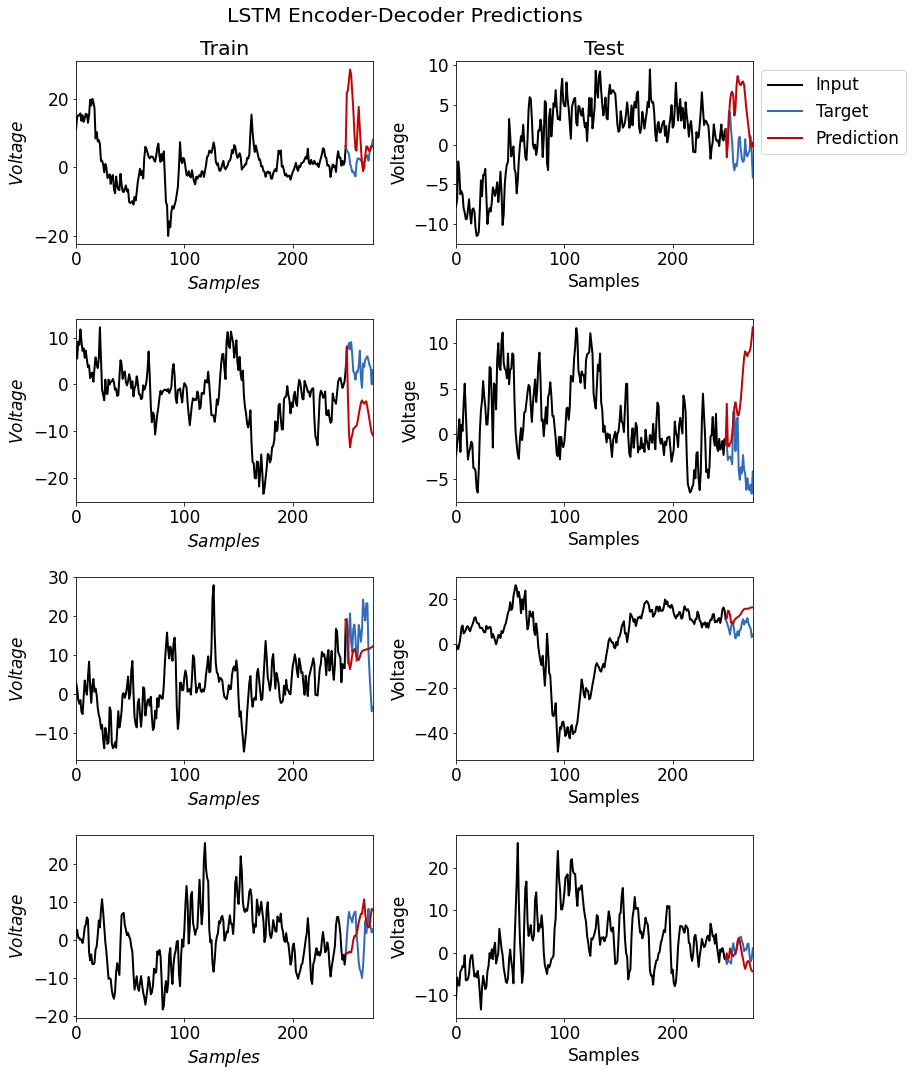

In [24]:
# plot predictions on train/test data
# import plotting 
plotting.plot_train_test_results(model, Xtrain, Ytrain, Xtest, Ytest,num_rows=4)


Save the model and the related data after the training - **Make sure you use informative correct name**

In [ ]:
torch.save(model,'model_H14.ckpt')

In [ ]:
data_to_pickle = [Xtrain, Ytrain, Xtest, Ytest]
open_file = open('data_model_H14', "wb")
pickle.dump(data_to_pickle, open_file)
open_file.close()

Load the model and the related data - **Run it only if you wish to use old saved model**. make sure you enter needed model name.

In [ ]:
model = torch.load('model_H7.ckpt')

In [ ]:
open_file = open('data_model_H7', "rb")
loaded_list = pickle.load(open_file)
Xtrain, Ytrain, Xtest, Ytest = loaded_list[0], loaded_list[1], loaded_list[2], loaded_list[3]
open_file.close()

In [ ]:
# convert windowed data from np.array to PyTorch tensor
X_train, Y_train, X_test, Y_test = generate_dataset.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

investigate the model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

In [ ]:
import  tqdm

In [ ]:
# return- MSE, MSE of normalized samples, R2 score
def compute_loses(y,y_pred):
  normlized_y = (y-y.min())/(y.max()-y.min())
  normlized_y_pred = (y_pred-y_pred.min())/(y_pred.max()-y_pred.min())
  return ([mean_squared_error(y,y_pred),mean_squared_error(normlized_y,normlized_y_pred),r2_score(y,y_pred)])

In [ ]:
predictions = []
for i in tqdm.tqdm(range(X_test.shape[1])):
      X_test_plt = X_test[:, i, :]
      Y_test_pred = model.predict(X_test_plt, target_len = ow)
      predictions.append(Y_test_pred)
      # loses.append(compute_loses(Ytest[:,i],Y_test_pred))

100%|██████████| 35946/35946 [05:26<00:00, 110.22it/s]


In [ ]:
predictions = [p[:,0] for p in predictions] # reduce dimantion

In [ ]:
loses= []
for i in tqdm.tqdm(range(Y_test.shape[1])):
    loses.append(compute_loses(Ytest[:,i],predictions[i]) )

100%|██████████| 35946/35946 [00:19<00:00, 1807.75it/s]


In [ ]:
results_df = pd.DataFrame(loses,columns=['mse','nmse','r2'])

Text(0.5, 0, 'MSE Value')

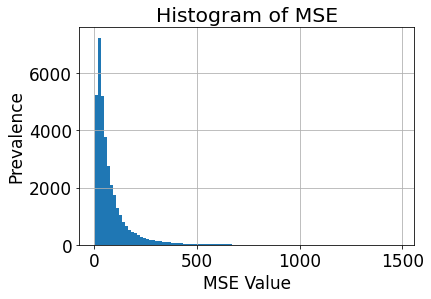

In [ ]:
results_df.mse.hist(bins=100)
plt.title('Histogram of MSE')
plt.ylabel('Prevalence')
plt.xlabel('MSE Value')

Text(0.5, 0, 'R squared score')

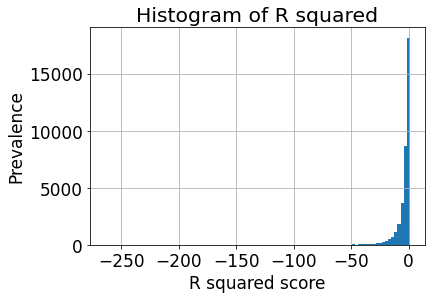

In [ ]:
results_df.r2.hist(bins=100)
plt.title('Histogram of R squared')
plt.ylabel('Prevalence')
plt.xlabel('R squared score')

In [ ]:
results_df.r2.max()

0.9350387046396176

In [ ]:
argmin = results_df.mse.argmax()

In [ ]:
results_df.shape

(35946, 3)

In [ ]:
# argmax = np.argmax(results_df[results_df.r2>0]['r2'])

In [ ]:
# len(results_df[results_df.r2>0]['r2']) / len(results_df['r2'])

In [ ]:
# results_df[results_df.r2>0]['r2'][5]

In [ ]:
# results_df.to_csv('./results_df_H14.csv')

In [ ]:
# argmax=35944
# plt.plot(predictions[argmax])
# plt.plot(Ytest[:,argmax])

In [ ]:
# argmin=35944
# plt.plot(predictions[argmin])
# plt.plot(Ytest[:,argmin])